In [1]:
import XGBoostModel
import numpy as np
from Utils import *
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import folium
%matplotlib inline
from sklearn.linear_model import LinearRegression
import branca.colormap as cm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import f_oneway
from scipy.stats import ttest_1samp
import geopy.distance
from scipy.stats import linregress
import branca.colormap as cm
import cartopy.crs as ccrs
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2

/Users/monicazhu/Documents/Python/UrbanOH/urbanoh_env/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [3]:
omi = pd.read_pickle(os.path.join(sat_aks_sr_output_path, 'ml_wrf_omi_filer_aks_update.pkl'))
omi_annual = omi.groupby(['year_y','xlon','xlat','city']).agg('mean').reset_index()

In [4]:
omi_annual_dist = omi.groupby(['xlon','xlat','city'])['no'].agg('mean').reset_index()
site_lon = []
site_lat = []
for loc_ind in np.arange(1,50):
    longitude, latitude, radius = collect_info_for_loc(loc_ind)
    site_lon.append(longitude)
    site_lat.append(latitude)
site=pd.DataFrame()
site.loc[:,'city'] = np.arange(1,50)
site.loc[:,'site_lon'] = site_lon
site.loc[:,'site_lat'] = site_lat
omi_annual_dist = omi_annual_dist.merge(site, on='city')
omi_annual_dist.loc[:,'dist'] = omi_annual_dist.apply(lambda row: geopy.distance.distance((row['site_lat'], row['site_lon']), (row['xlat'], row['xlon'])).km, axis=1)
omi_annual_dist.loc[:, 'dist_bins'] = pd.cut(omi_annual_dist.loc[:,'dist'], np.arange(0,100,20), labels=False)
bin_means = omi_annual_dist.groupby(['dist_bins'])['dist'].agg('mean').reset_index().rename(columns={'dist':'dist_bins_mean'})
omi_annual_dist = omi_annual_dist.merge(bin_means, on='dist_bins')
omi_annual_ap_dist = omi_annual.merge(omi_annual_dist,on=['xlon','xlat','city'])

In [5]:
omi_annual_ap_dist.loc[:,'norm_wrf_no2_vcd'] = omi_annual_ap_dist.loc[:, 'wrf_no2_vcd']/omi_annual_ap_dist.query('year_y==2005').loc[:, 'wrf_no2_vcd'].mean()
omi_annual_ap_dist.loc[:,'norm_no2_vcd'] = omi_annual_ap_dist.loc[:, 'no2_vcd']/omi_annual_ap_dist.query('year_y==2005').loc[:, 'no2_vcd'].mean()
omi_annual_ap_dist.loc[:,'norm_wrf_hcho_vcd_aks'] = omi_annual_ap_dist.loc[:, 'wrf_hcho_vcd_aks']/omi_annual_ap_dist.query('year_y==2005').loc[:, 'wrf_hcho_vcd_aks'].mean()
omi_annual_ap_dist.loc[:,'norm_hcho_vcd_aks'] = omi_annual_ap_dist.loc[:, 'hcho_vcd_aks']/omi_annual_ap_dist.query('year_y==2005').loc[:, 'hcho_vcd_aks'].mean()
omi_annual_ap_dist.loc[:,'norm_wrf_oh'] = omi_annual_ap_dist.loc[:, 'wrf_oh']/omi_annual_ap_dist.query('year_y==2005').loc[:, 'wrf_oh'].mean()
omi_annual_ap_dist.loc[:,'norm_omi_pred'] = omi_annual_ap_dist.loc[:, 'omi_pred']/omi_annual_ap_dist.query('year_y==2005').loc[:, 'omi_pred'].mean()

omi_annual_ap_dist.loc[:, 'Dist. from city center'] = ''
indx = omi_annual_ap_dist['dist_bins'] == 0
omi_annual_ap_dist.loc[indx, 'Dist. from city center'] = '0-20km'
indx = omi_annual_ap_dist['dist_bins'] == 1
omi_annual_ap_dist.loc[indx, 'Dist. from city center'] = '20-40km'
indx = omi_annual_ap_dist['dist_bins'] == 2
omi_annual_ap_dist.loc[indx, 'Dist. from city center'] = '40-60km'
indx = omi_annual_ap_dist['dist_bins'] == 3
omi_annual_ap_dist.loc[indx, 'Dist. from city center'] = '60-80km'


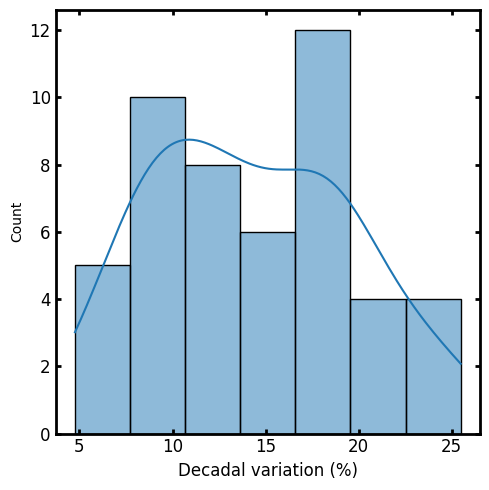

In [6]:
omi_annual_ap_dist_year_avg = omi_annual_ap_dist.groupby(['city', 'year_y']).agg('mean').loc[:, ['omi_pred','no2_vcd']].reset_index()
annual_norm_diff_broad = omi_annual_ap_dist_year_avg.groupby(['city']).apply(lambda x: (np.max(x)-np.min(x))/ np.mean(x))

plt.figure(figsize=(5,5))
sns.histplot(annual_norm_diff_broad['omi_pred']*100, kde=True)
plt.xlabel('Decadal variation (%)', fontsize=12)
#plt.ylabel('OH (10$^6$ molec cm$^{-3}$)', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([0.5,1.2])
#plt.ylim([8,13])
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()
#plt.savefig(os.path.join(sat_aks_sr_output_path, 'oh_decadal_change_cities.png'))

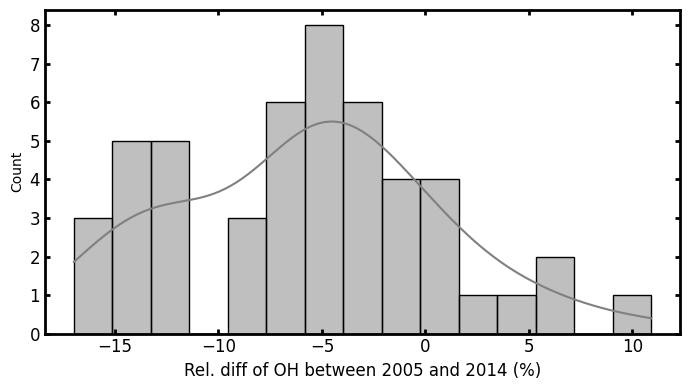

In [40]:
omi_annual_ap_dist_year_avg = omi_annual_ap_dist.groupby(['city', 'year_y']).agg('mean').loc[:, ['omi_pred','no2_vcd','hcho_vcd_aks']].reset_index()
decadal_norm_05 = omi_annual_ap_dist_year_avg.query('year_y==2005')
decadal_norm_14 = omi_annual_ap_dist_year_avg.query('year_y==2014')
decadal_norm = decadal_norm_05.merge(decadal_norm_14,on='city')

decadal_norm_diff = (decadal_norm ['omi_pred_y'] - decadal_norm ['omi_pred_x'])/decadal_norm ['omi_pred_x']

plt.figure(figsize=(7,4))
sns.histplot(decadal_norm_diff*100, kde=True, bins=15,color='grey')
plt.xlabel('Rel. diff of OH between 2005 and 2014 (%)', fontsize=12)
#plt.ylabel('OH (10$^6$ molec cm$^{-3}$)', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([0.5,1.2])
#plt.ylim([8,13])
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()
#plt.savefig(os.path.join(sat_aks_sr_output_path, 'oh_rel_change_dist.png'))

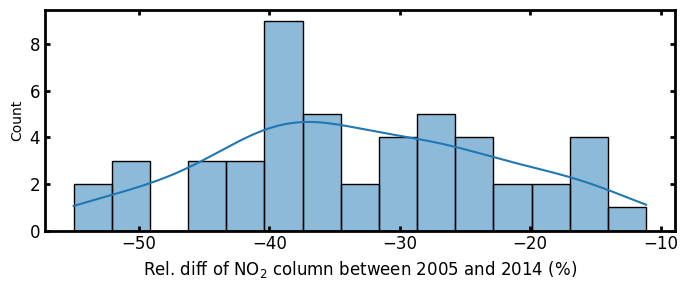

In [41]:
shortname, lon, lat= read_site_location()

decadal_norm['diff'] = decadal_norm_diff*100
decadal_norm['shortname'] = shortname
decadal_norm.sort_values(by='diff')
decadal_norm.to_csv('oh_diff.csv')
decadal_norm_diff_no2 = (decadal_norm ['no2_vcd_y'] - decadal_norm ['no2_vcd_x'])/decadal_norm ['no2_vcd_x']
plt.figure(figsize=(7,3))
sns.histplot(decadal_norm_diff_no2*100, kde=True, bins=15,color='tab:blue')
plt.xlabel('Rel. diff of NO$_2$ column between 2005 and 2014 (%)', fontsize=12)
#plt.ylabel('OH (10$^6$ molec cm$^{-3}$)', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([0.5,1.2])
#plt.ylim([8,13])
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()

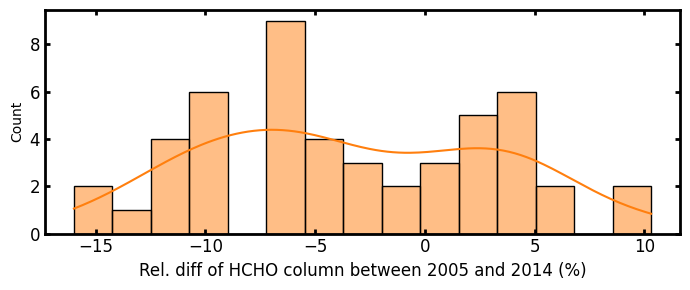

In [42]:
decadal_norm_diff_hcho = (decadal_norm ['hcho_vcd_aks_y'] - decadal_norm ['hcho_vcd_aks_x'])/decadal_norm ['hcho_vcd_aks_x']
plt.figure(figsize=(7,3))
sns.histplot(decadal_norm_diff_hcho*100, kde=True, bins=15,color='tab:orange')
plt.xlabel('Rel. diff of HCHO column between 2005 and 2014 (%)', fontsize=12)
#plt.ylabel('OH (10$^6$ molec cm$^{-3}$)', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([0.5,1.2])
#plt.ylim([8,13])
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()

In [10]:
def collect_fit_detail(loc_ind, query_str):
    this_omi_annual = omi_annual_ap_dist[omi_annual_ap_dist['city']==loc_ind]
    this_omi_annual['year_y'] = this_omi_annual['year_y'].astype(int)#.astype(str)
    x = this_omi_annual.query(query_str)['norm_no2_vcd']
    y = this_omi_annual.query(query_str)['norm_omi_pred']
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    fit_y = slope*x+intercept
    result = [x,fit_y,r_value,std_err,slope]
    return result
la_2005 =  collect_fit_detail(23, 'year_y==2005')
la_2014 =  collect_fit_detail(23, 'year_y==2014')
de_2005 =  collect_fit_detail(14, 'year_y==2005')
de_2014 =  collect_fit_detail(14, 'year_y==2014')

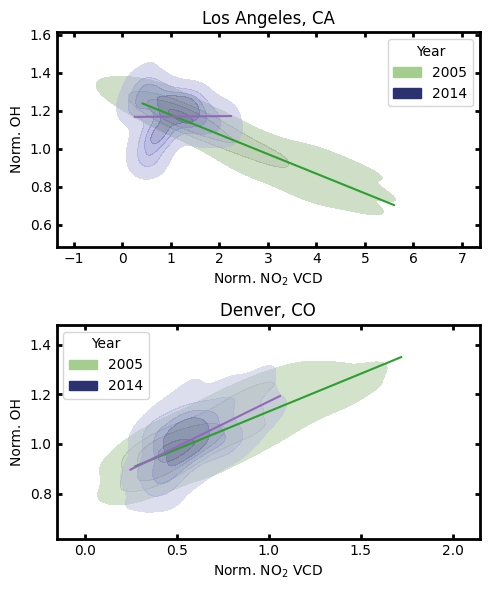

In [11]:
omi_annual_ap_dist_be = omi_annual_ap_dist.query('year_y==2005 or year_y==2014 ')
omi_annual_ap_dist_be['year_y'] = omi_annual_ap_dist_be['year_y'].astype(int)
omi_annual_ap_dist_be = omi_annual_ap_dist_be.rename(columns={'year_y':'Year'})

plt.figure(figsize=(5,6))
plt.subplot(2,1,1)
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
ax=sns.kdeplot(x='norm_no2_vcd',y='norm_omi_pred',hue='Year',data=omi_annual_ap_dist_be.query('city==23'),
            palette='crest',fill=True,alpha=0.5,levels=5)
sns.lineplot(x=la_2005[0],y=la_2005[1],color='tab:green')
sns.lineplot(x=la_2014[0],y=la_2014[1],color='tab:purple')
plt.xlabel('Norm. NO$_2$ VCD')
plt.ylabel('Norm. OH')

plt.title('Los Angeles, CA')
plt.tight_layout()


plt.subplot(2,1,2)
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
ax=sns.kdeplot(x='norm_no2_vcd',y='norm_omi_pred',hue='Year',data=omi_annual_ap_dist_be.query('city==14'),
            palette='crest',fill=True,alpha=0.5,levels=5)
sns.lineplot(x=de_2005[0],y=de_2005[1],color='tab:green')
sns.lineplot(x=de_2014[0],y=de_2014[1],color='tab:purple')
plt.xlabel('Norm. NO$_2$ VCD')
plt.ylabel('Norm. OH')
plt.title('Denver, CO')

#ax.get_legend().remove()
plt.tight_layout()

In [12]:
def calc_oh_no2_gradient_norm(column):
    x = column['norm_no2_vcd']
    y = column['norm_omi_pred']
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

def calc_oh_no2_gradient_norm_err(column):
    x = column['norm_no2_vcd']
    y = column['norm_omi_pred']
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return std_err

def calc_oh_no2_gradient_norm_r(column):
    x = column['norm_no2_vcd']
    y = column['norm_omi_pred']
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return r_value


def oh_no2_gradient_norm_nobin(loc_ind):
    this_omi_annual = omi_annual_ap_dist[omi_annual_ap_dist['city']==loc_ind]
    this_omi_annual['year_y'] = this_omi_annual['year_y'].astype(int)#.astype(str)
    this_gradients = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm).reset_index().rename(columns={0:'grad'})
    this_gradients.loc[:,'std'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_err).reset_index().rename(columns={0:'err'}).loc[:,'err']
    this_gradients.loc[:,'r_value'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_r).reset_index().rename(columns={0:'r'}).loc[:,'r']
    this_gradients.loc[:,'r2'] = this_gradients.loc[:,'r_value']**2
    this_gradients.loc[:,'city'] = loc_ind
    this_gradients.loc[:,'shortname'] = shortname[loc_ind-1]
    return this_gradients


In [13]:
gradient = pd.DataFrame()
city_index= np.arange(1,50)
for loc_ind in city_index:

    this_data = oh_no2_gradient_norm_nobin(loc_ind)
    gradient = pd.concat([gradient, this_data])
gradient=gradient.rename(columns={'year_y':'Year'})

<ipython-input-12-9c6eda8a8b22>:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm).reset_index().rename(columns={0:'grad'})
<ipython-input-12-9c6eda8a8b22>:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'std'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_err).reset_index().rename(columns={0:'err'}).loc[:,'err']
<ipython-input-12-9c6eda8a8b22>:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'r_value'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_r).reset_index().rename(columns={0:'

<ipython-input-12-9c6eda8a8b22>:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'r_value'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_r).reset_index().rename(columns={0:'r'}).loc[:,'r']
<ipython-input-12-9c6eda8a8b22>:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm).reset_index().rename(columns={0:'grad'})
<ipython-input-12-9c6eda8a8b22>:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'std'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_err).reset_index().rename(columns={0:'err'

<ipython-input-12-9c6eda8a8b22>:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'std'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_err).reset_index().rename(columns={0:'err'}).loc[:,'err']
<ipython-input-12-9c6eda8a8b22>:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'r_value'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_r).reset_index().rename(columns={0:'r'}).loc[:,'r']
<ipython-input-12-9c6eda8a8b22>:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm).reset_index().rename(colu

<ipython-input-12-9c6eda8a8b22>:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'r_value'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_r).reset_index().rename(columns={0:'r'}).loc[:,'r']
<ipython-input-12-9c6eda8a8b22>:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm).reset_index().rename(columns={0:'grad'})
<ipython-input-12-9c6eda8a8b22>:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  this_gradients.loc[:,'std'] = this_omi_annual.groupby('year_y')['norm_no2_vcd','norm_omi_pred'].apply(calc_oh_no2_gradient_norm_err).reset_index().rename(columns={0:'err'

In [16]:
this_data_2014 = this_data.iloc[49:,:]
this_data_2005 = this_data.iloc[0:49,:]
errorbars = this_data_2005.merge(this_data_2014,on='shortname')
order_values = pd.concat([errorbars['grad_x'],errorbars['grad_y']])
order_std = pd.concat([errorbars['std_x'],errorbars['std_y']])

<ErrorbarContainer object of 3 artists>

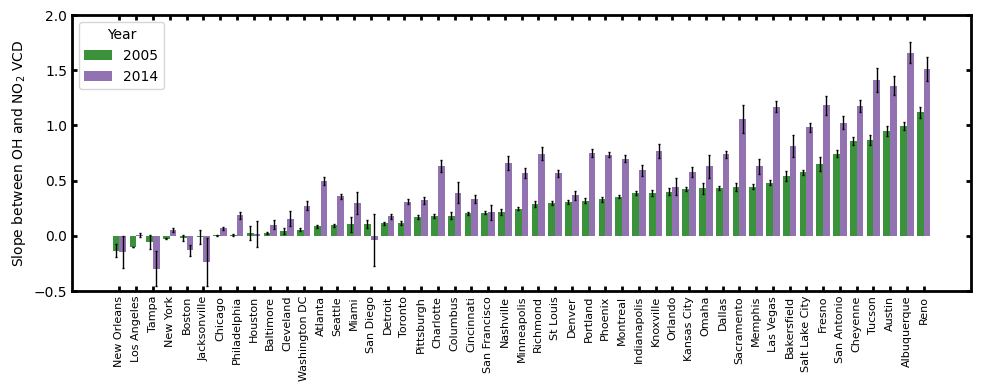

In [17]:
colors = [ "tab:green","tab:purple"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(10,4))

#gradient['city'] = gradient['city'].astype(str)
#gradient=gradient.rename(columns={'year_y':'Year'})
this_data = gradient.sort_values(by=['Year','grad']).query("Year==2005 or Year==2014")

abar = sns.barplot(x= 'shortname', y='grad', hue='Year', data=this_data,palette=customPalette)
#abar.get_legend().remove()
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('')
plt.ylabel('Slope between OH and NO$_2$ VCD')
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()
plt.ylim([-0.5, 2.0])
x_list = []
for patch in abar.patches:
    x_list.append(patch.get_xy()[0]+(patch._width/2))

plt.errorbar(x_list, order_values, order_std,
             marker=None, mec='black', zorder=10, elinewidth=1, capsize=1, ecolor='black',
             linestyle="None", markersize=10)

<ipython-input-18-bcbc0bb5ad32>:15: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(sa,cmap='coolwarm', orientation='horizontal',ticklocation='auto',fraction=0.074, pad=0.1,


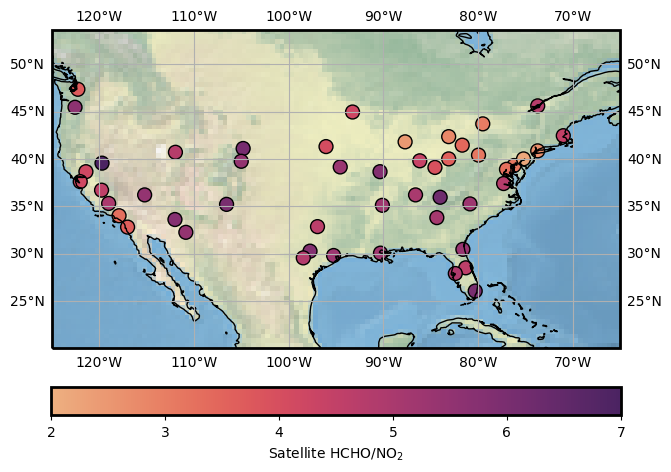

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ratio_data = pd.read_csv('/Users/monicazhu/Documents/MATLAB/PAN_Data/Workspaces/HCHO/hcho_no2_ratio.csv')

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_extent([-125, -65, 20, 50], ccrs.Geodetic())
sa = ax.scatter(ratio_data['city_lon'].values, ratio_data['city_lat'], c=ratio_data['ratio'],s=100, edgecolors='k',transform=ccrs.PlateCarree(), cmap='flare', vmin=2, vmax=7)
ax.stock_img()
ax.coastlines()
ax.gridlines(x_inline=False, draw_labels=True)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sa,cmap='coolwarm', orientation='horizontal',ticklocation='auto',fraction=0.074, pad=0.1,
             label='Satellite HCHO/NO$_2$')

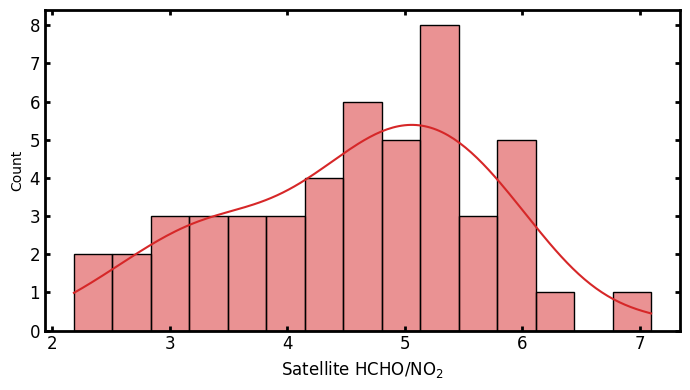

In [19]:
plt.figure(figsize=(7,4))
sns.histplot(ratio_data['ratio'], kde=True, bins=15,color='tab:red')
plt.xlabel('Satellite HCHO/NO$_2$', fontsize=12)
#plt.ylabel('OH (10$^6$ molec cm$^{-3}$)', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([0.5,1.2])
#plt.ylim([8,13])
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()

In [32]:
decadal_norm['rel_diff'] = decadal_norm_diff
decadal_norm['rel_diff_no2'] = decadal_norm_diff_no2
decadal_norm = decadal_norm.merge(site,on='city')


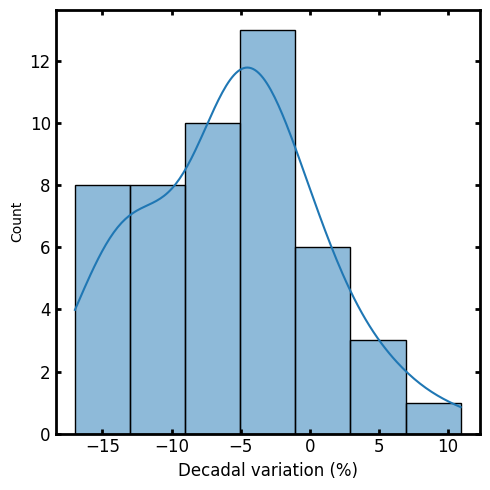

In [27]:
omi_annual_ap_dist_year_avg = omi_annual_ap_dist.groupby(['city', 'year_y']).agg('mean').loc[:, ['omi_pred']].reset_index()
decadal_norm_05 = omi_annual_ap_dist_year_avg.query('year_y==2005')
decadal_norm_14 = omi_annual_ap_dist_year_avg.query('year_y==2014')
decadal_norm = decadal_norm_05.merge(decadal_norm_14,on='city')

decadal_norm_diff = (decadal_norm ['omi_pred_y'] - decadal_norm ['omi_pred_x'])/decadal_norm ['omi_pred_x']
plt.figure(figsize=(5,5))
sns.histplot(decadal_norm_diff*100, kde=True, color='tab:blue')
plt.xlabel('Decadal variation (%)', fontsize=12)
#plt.ylabel('OH (10$^6$ molec cm$^{-3}$)', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([0.5,1.2])
#plt.ylim([8,13])
plt.tick_params(which='both', bottom=True,top=True, left=True, right=True, direction='in', width=2)
plt.tight_layout()

<ipython-input-33-1a5f35159c52>:13: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(sa,cmap='coolwarm', orientation='horizontal',ticklocation='auto',fraction=0.074, pad=0.1,


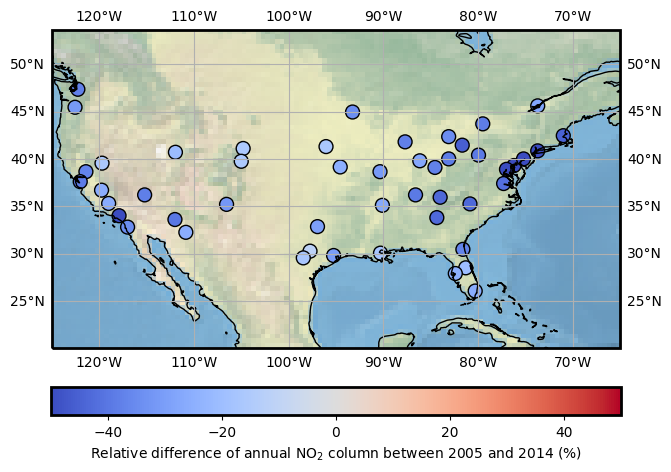

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_extent([-125, -65, 20, 50], ccrs.Geodetic())
sa = ax.scatter(decadal_norm['site_lon'].values, decadal_norm['site_lat'], c=decadal_norm['rel_diff_no2']*100,s=100, edgecolors='k',transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-50, vmax=50)
ax.stock_img()
ax.coastlines()
ax.gridlines(x_inline=False, draw_labels=True)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sa,cmap='coolwarm', orientation='horizontal',ticklocation='auto',fraction=0.074, pad=0.1,
             label='Relative difference of annual NO$_2$ column between 2005 and 2014 (%)')
